# **Importing libraries and dataset**

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# **DataFrame & arranging data**

In [0]:
df = pd.read_csv('/content/drive/My Drive/NITD Internship/Data.csv', index_col='Date', parse_dates=True)

In [0]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [17]:
df.head()

,Temperature,Humidity,Carbon Monoxide,Nitrogen Dioxide,Dust (PM2.5),Dust (PM10)
Date,,,,,,
2020-04-16 11:08:00,30,36,44,1.42,37,52
2020-04-16 11:08:00,30,36,44,1.42,37,52
2020-04-16 11:07:00,30,36,44,1.41,37,52
2020-04-16 11:07:00,30,36,44,1.41,37,52
2020-04-16 11:07:00,30,36,44,1.42,37,52


# **Handling missing data and replacing them with the column mean**

In [0]:
df.fillna(df.mean(),inplace=True)

# **Resampling of data**

In [0]:
# keeping only one occurence of date time and merging duplicates by doing mean of them
df = df.groupby('Date').mean()

In [26]:
df.head()

,Temperature,Humidity,Carbon Monoxide,Nitrogen Dioxide,Dust (PM2.5),Dust (PM10)
Date,,,,,,
2020-03-29 13:48:00,31.0,18.0,44.0,1.460000,12.000000,17.000000
2020-03-29 13:49:00,31.0,18.0,43.5,1.475000,12.166667,17.166667
2020-03-29 13:50:00,31.0,18.0,43.5,1.471667,13.000000,18.000000
2020-03-29 13:51:00,31.0,18.0,43.5,1.456667,13.000000,18.000000
2020-03-29 13:52:00,31.2,18.0,43.6,1.450000,13.000000,18.000000


**Visualization**

# **Data Visualization**

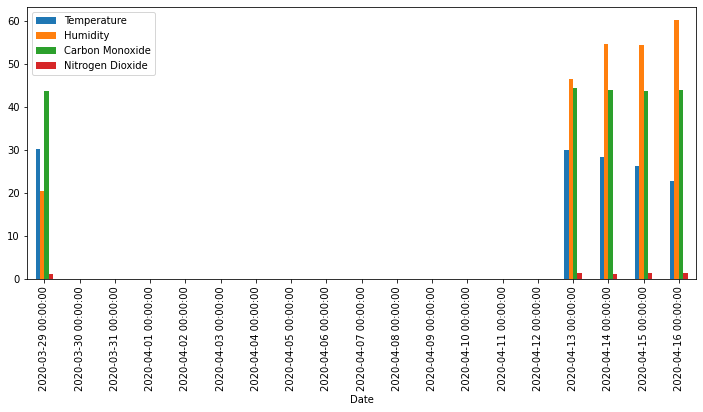

In [84]:
graph = df[['Temperature','Humidity','Carbon Monoxide','Nitrogen Dioxide']].resample(rule='D').mean().plot.bar();

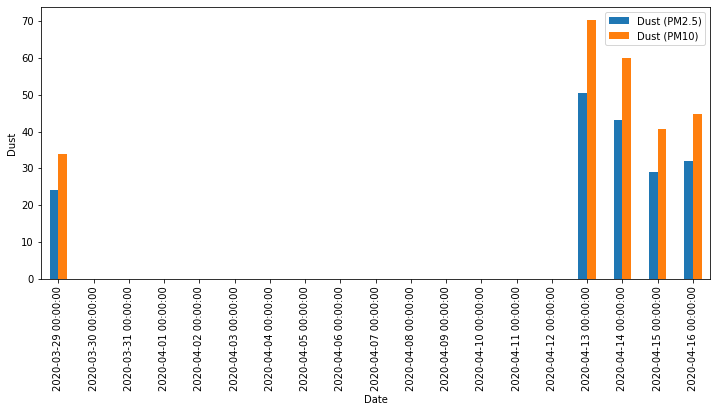

In [83]:
graph = df[['Dust (PM2.5)','Dust (PM10)']].resample(rule='D').mean().plot.bar();
graph.set(ylabel='Dust');